# Shapely Validate Example 

> Parallel handling of of a mixture of valid and invalid geometries using [regular](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.udf.html?highlight=udf#pyspark.sql.functions.udf) and [vectorized pandas](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.pandas_udf.html?highlight=pandas%20udf#pyspark.sql.functions.pandas_udf) UDFs.

__Libraries__

<p/>

* 'databricks-mosaic' (installs geopandas and dependencies as well as keplergl)

--- 
 __Last Update__ 22 NOV 2023 [Mosaic 0.3.12]

## Setup

### Imports

In [0]:
%pip install "databricks-mosaic<0.4,>=0.3" --quiet # <- Mosaic 0.3 series
# %pip install "databricks-mosaic<0.5,>=0.4" --quiet # <- Mosaic 0.4 series (as available)

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
#  - choose option-1 or option-2 below, essential for REPARTITION!
# spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <- option-1: turn off completely for full control
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False) # <- option-2: just tweak partition management
spark.conf.set("spark.sql.shuffle.partitions", 10_000)                 # <-- default is 200

# -- import databricks + spark functions
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
# mos.enable_gdal(spark) # <- not needed for this example

# --other imports
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import shapely
import warnings

warnings.simplefilter("ignore")

### Data

> Generating a dataset with some bad data, adapted from [here](https://github.com/kleunen/boost_geometry_correct).

These are the types of issues that can come up with geometries [[1](https://stackoverflow.com/questions/49902090/dataset-of-invalid-geometries-in-boostgeometry)]...

```
//Hole Outside Shell
check("POLYGON((0 0, 10 0, 10 10, 0 10, 0 0), (15 15, 15 20, 20 20, 20 15, 15 15))");
//Nested Holes
check("POLYGON((0 0, 10 0, 10 10, 0 10, 0 0), (2 2, 2 8, 8 8, 8 2, 2 2), (3 3, 3 7, 7 7, 7 3, 3 3))");
//Disconnected Interior
check("POLYGON((0 0, 10 0, 10 10, 0 10, 0 0), (5 0, 10 5, 5 10, 0 5, 5 0))");
//Self Intersection
check("POLYGON((0 0, 10 10, 0 10, 10 0, 0 0))");
//Ring Self Intersection
check("POLYGON((5 0, 10 0, 10 10, 0 10, 0 0, 5 0, 3 3, 5 6, 7 3, 5 0))");
//Nested Shells
check<multi>("MULTIPOLYGON(((0 0, 10 0, 10 10, 0 10, 0 0)),(( 2 2, 8 2, 8 8, 2 8, 2 2)))");
//Duplicated Rings
check<multi>("MULTIPOLYGON(((0 0, 10 0, 10 10, 0 10, 0 0)),((0 0, 10 0, 10 10, 0 10, 0 0)))");
//Too Few Points
check("POLYGON((2 2, 8 2))");
//Invalid Coordinate
check("POLYGON((NaN 3, 3 4, 4 4, 4 3, 3 3))");
//Ring Not Closed
check("POLYGON((0 0, 0 10, 10 10, 10 0))");
```

In [0]:
test_wkts = []

__[1a] Polygon self-intersection__

> Exterior xy plot with shapely (to see the lines).

In [0]:
test_wkts.append((1, """POLYGON ((5 0, 2.5 9, 9.5 3.5, 0.5 3.5, 7.5 9, 5 0))"""))

Out[107]: [<matplotlib.lines.Line2D at 0x7f8473f33df0>]

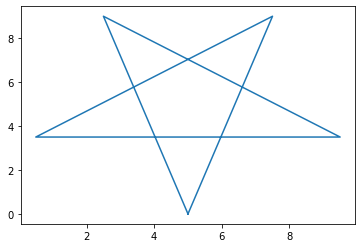

In [0]:
plt.plot(*shapely.wkt.loads(test_wkts[0][1]).exterior.xy)

__[1b] Polygon with hole inside__

> Exterior xy plot with shapely (to see the lines).

In [0]:
test_wkts.append((2, """POLYGON ((55 10, 141 237, 249 23, 21 171, 252 169, 24 89, 266 73, 55 10))"""))

Out[108]: [<matplotlib.lines.Line2D at 0x7f8474069700>]

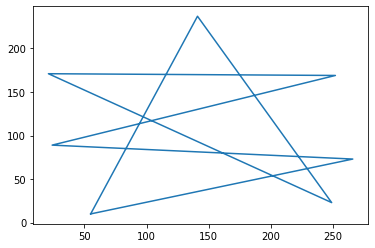

In [0]:
plt.plot(*shapely.wkt.loads(test_wkts[1][1]).exterior.xy)

__[1c] Polygon with multiple intersections at same point__

> Exterior xy plot with shapely (to see the lines).

In [0]:
test_wkts.append((3, """POLYGON ((0 0, 10 0, 0 10, 10 10, 0 0, 5 0, 5 10, 0 10, 0 5, 10 5, 10 0, 0 0))"""))

Out[109]: [<matplotlib.lines.Line2D at 0x7f8474120670>]

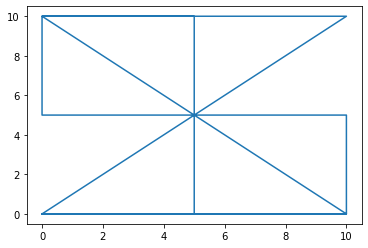

In [0]:
plt.plot(*shapely.wkt.loads(test_wkts[2][1]).exterior.xy)

__[1d] Valid Polygon__

In [0]:
test_wkts.append((4, """POLYGON (( -84.3641541604937 33.71316821215546, -84.36414611386687 33.71303657522174, -84.36409515189553 33.71303657522174, -84.36410319852232 33.71317267442025, -84.3641541604937 33.71316821215546 ))"""))

Out[115]: [<matplotlib.lines.Line2D at 0x7f846ea218e0>]

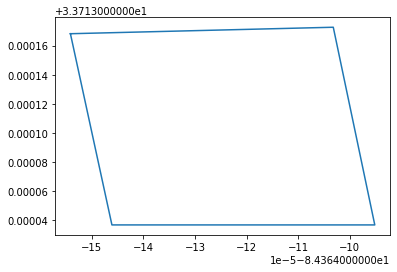

In [0]:
plt.plot(*shapely.wkt.loads(test_wkts[3][1]).exterior.xy)

__[2] Make Spark DataFrame from `test_wkts`__

In [0]:
df = (
  spark
    .createDataFrame(test_wkts, schema=['row_id', 'geom_wkt'])
)
print(f"count? {df.count():,}")
df.display()

count? 4


row_id,geom_wkt
1,"POLYGON ((5 0, 2.5 9, 9.5 3.5, 0.5 3.5, 7.5 9, 5 0))"
2,"POLYGON ((55 10, 141 237, 249 23, 21 171, 252 169, 24 89, 266 73, 55 10))"
3,"POLYGON ((0 0, 10 0, 0 10, 10 10, 0 0, 5 0, 5 10, 0 10, 0 5, 10 5, 10 0, 0 0))"
4,"POLYGON (( -84.3641541604937 33.71316821215546, -84.36414611386687 33.71303657522174, -84.36409515189553 33.71303657522174, -84.36410319852232 33.71317267442025, -84.3641541604937 33.71316821215546 ))"


## Regular UDF: Test + Fix Validity

> Will use Mosaic to initially test; then only apply UDF to invalids

### UDFs

In [0]:
@udf(returnType=StringType())
def explain_wkt_validity(geom_wkt:str) -> str:
    """
    Add explanation of validity or invalidity
    """
    from shapely import wkt
    from shapely.validation import explain_validity

    _geom = wkt.loads(geom_wkt)
    return explain_validity(_geom)


@udf(returnType=StringType())
def make_wkt_valid(geom_wkt:str) -> str:
    """
    - test for wkt being valid
    - attempts to make valid
    - may have to change type, e.g. POLYGON to MULTIPOLYGON
     returns valid wkt
    """
    from shapely import wkt 
    from shapely.validation import make_valid

    _geom = wkt.loads(geom_wkt)
    if _geom.is_valid:
        return geom_wkt
    _geom_fix = make_valid(_geom)
    return _geom_fix.wkt

### Test Validity

In [0]:
df_test_valid = (
  df
    .withColumn("is_valid", mos.st_isvalid("geom_wkt"))
)

df_test_valid.display()

row_id,geom_wkt,is_valid
1,"POLYGON ((5 0, 2.5 9, 9.5 3.5, 0.5 3.5, 7.5 9, 5 0))",false
2,"POLYGON ((55 10, 141 237, 249 23, 21 171, 252 169, 24 89, 266 73, 55 10))",false
3,"POLYGON ((0 0, 10 0, 0 10, 10 10, 0 0, 5 0, 5 10, 0 10, 0 5, 10 5, 10 0, 0 0))",false
4,"POLYGON (( -84.3641541604937 33.71316821215546, -84.36414611386687 33.71303657522174, -84.36409515189553 33.71303657522174, -84.36410319852232 33.71317267442025, -84.3641541604937 33.71316821215546 ))",true


__Let's get an explanation for our 3 invalids__

_Recommend `explain_wkt_valid` only to help you understand, not as part of production pipeline, so doing separately._

In [0]:
display(
  df_test_valid
  .select(
    "*",
    F
      .when(col("is_valid") == False, explain_wkt_validity("geom_wkt"))
      .otherwise(F.lit(None))
      .alias("invalid_explain")
  )
  .filter("is_valid = false")
)

row_id,geom_wkt,is_valid,invalid_explain
1,"POLYGON ((5 0, 2.5 9, 9.5 3.5, 0.5 3.5, 7.5 9, 5 0))",false,Self-intersection[4.02777777777778 3.5]
2,"POLYGON ((55 10, 141 237, 249 23, 21 171, 252 169, 24 89, 266 73, 55 10))",false,Self-intersection[201.596683628707 53.7705737848745]
3,"POLYGON ((0 0, 10 0, 0 10, 10 10, 0 0, 5 0, 5 10, 0 10, 0 5, 10 5, 10 0, 0 0))",false,Ring Self-intersection[5 10]


### Fix Validity

In [0]:
df_valid = (
  df
    .withColumnRenamed("geom_wkt", "orig_geom_wkt")
    .withColumn("is_orig_valid", mos.st_isvalid("orig_geom_wkt"))
  .select(
    "*",
    F
      .when(col("is_orig_valid") == False, make_wkt_valid("orig_geom_wkt"))
      .otherwise(col("orig_geom_wkt"))
      .alias("geom_wkt")
  )
  .withColumn("is_valid", mos.st_isvalid("geom_wkt"))
  .drop("orig_geom_wkt")
)

print(f"""count? {df_valid.count():,}""")
print(f"""num orig invalid? {df_valid.filter(col("is_orig_valid") == False).count():,}""")
print(f"""num final invalid? {df_valid.filter(col("is_valid") == False).count():,}""")
display(df_valid)

count? 4
num orig invalid? 3
num final invalid? 0


row_id,is_orig_valid,geom_wkt,is_valid
1,false,"MULTIPOLYGON (((0.5 3.5, 3.3957654723127035 5.7752442996742674, 4.027777777777778 3.5, 0.5 3.5)), ((2.5 9, 5 7.035714285714286, 3.3957654723127035 5.7752442996742674, 2.5 9)), ((7.5 9, 6.6042345276872965 5.7752442996742674, 5 7.035714285714286, 7.5 9)), ((9.5 3.5, 5.972222222222222 3.5, 6.6042345276872965 5.7752442996742674, 9.5 3.5)), ((5 0, 4.027777777777778 3.5, 5.972222222222222 3.5, 5 0)))",true
2,false,"MULTIPOLYGON (((21 171, 115.68501587180901 170.1802163127982, 97.24514608274922 121.50753675330314, 21 171)), ((141 237, 174.98122638059246 169.66682920882604, 115.68501587180901 170.1802163127982, 141 237)), ((252 169, 186.85374007521938 146.1416631842875, 174.98122638059246 169.66682920882604, 252 169)), ((222.3085097882541 75.88869356771873, 161.30987316587914 79.92166127828898, 104.05263157894737 117.08864265927977, 186.85374007521938 146.1416631842875, 222.3085097882541 75.88869356771873)), ((266 73, 229.29693213749567 62.04126409792525, 222.3085097882541 75.88869356771873, 266 73)), ((249 23, 201.59668362870678 53.77057378487454, 229.29693213749567 62.04126409792525, 249 23)), ((55 10, 83.44063221452673 85.07004084532055, 161.30987316587914 79.92166127828898, 201.59668362870678 53.77057378487454, 55 10)), ((24 89, 94.27070148854622 113.6563864872092, 83.44063221452673 85.07004084532055, 24 89)), ((97.24514608274922 121.50753675330314, 104.05263157894737 117.08864265927977, 94.27070148854622 113.6563864872092, 97.24514608274922 121.50753675330314)))",true
3,false,"GEOMETRYCOLLECTION (MULTIPOLYGON (((10 5, 10 0, 5 0, 0 0, 5 5, 10 5)), ((5 5, 0 5, 0 10, 5 10, 10 10, 5 5))), MULTILINESTRING ((10 0, 5 5), (5 5, 0 10), (5 0, 5 5), (5 5, 5 10)))",true
4,true,"POLYGON (( -84.3641541604937 33.71316821215546, -84.36414611386687 33.71303657522174, -84.36409515189553 33.71303657522174, -84.36410319852232 33.71317267442025, -84.3641541604937 33.71316821215546 ))",true


In [0]:
fix_wkts = df_valid.orderBy('row_id').toJSON().collect()
fix_wkts

Out[118]: ['{"row_id":1,"is_orig_valid":false,"geom_wkt":"MULTIPOLYGON (((0.5 3.5, 3.3957654723127035 5.7752442996742674, 4.027777777777778 3.5, 0.5 3.5)), ((2.5 9, 5 7.035714285714286, 3.3957654723127035 5.7752442996742674, 2.5 9)), ((7.5 9, 6.6042345276872965 5.7752442996742674, 5 7.035714285714286, 7.5 9)), ((9.5 3.5, 5.972222222222222 3.5, 6.6042345276872965 5.7752442996742674, 9.5 3.5)), ((5 0, 4.027777777777778 3.5, 5.972222222222222 3.5, 5 0)))","is_valid":true}',
 '{"row_id":2,"is_orig_valid":false,"geom_wkt":"MULTIPOLYGON (((21 171, 115.68501587180901 170.1802163127982, 97.24514608274922 121.50753675330314, 21 171)), ((141 237, 174.98122638059246 169.66682920882604, 115.68501587180901 170.1802163127982, 141 237)), ((252 169, 186.85374007521938 146.1416631842875, 174.98122638059246 169.66682920882604, 252 169)), ((222.3085097882541 75.88869356771873, 161.30987316587914 79.92166127828898, 104.05263157894737 117.08864265927977, 186.85374007521938 146.1416631842875, 222.3085097882

__Row 1: Fixed [Self-Intersection]__ 

> Using GeoPandas to plot area for fixed.

Out[125]: <AxesSubplot:>

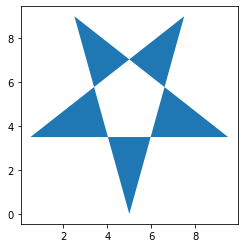

In [0]:
gpd.GeoSeries(shapely.wkt.loads(json.loads(fix_wkts[0])['geom_wkt'])).plot()

__Row 2: Fixed [Self-Intersection]__

> Using GeoPandas to plot area for fixed.

Out[126]: <AxesSubplot:>

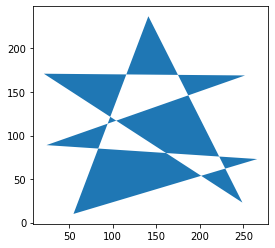

In [0]:
gpd.GeoSeries(shapely.wkt.loads(json.loads(fix_wkts[1])['geom_wkt'])).plot()

__Row 3: Fixed [Ring Self-Intersection]__

> Using GeoPandas to plot area for fixed.

Out[127]: <AxesSubplot:>

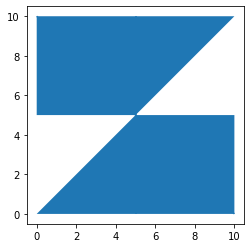

In [0]:
gpd.GeoSeries(shapely.wkt.loads(json.loads(fix_wkts[2])['geom_wkt'])).plot()

## Option: Vectorized Pandas UDF

> If you want to go further with performance, you can use a vectorized pandas UDF

__Note: We are using the Pandas Series [Vectorized UDF](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.pandas_udf.html) variant.__

In [0]:
from pyspark.sql.functions import pandas_udf

@pandas_udf(StringType())
def vectorized_make_wkt_valid(s:pd.Series) -> pd.Series:
    """
    - test for wkt being valid
    - attempts to make valid
    - may have to change type, e.g. POLYGON to MULTIPOLYGON
     returns valid wkt
    """
    from shapely import wkt 
    from shapely.validation import make_valid

    def to_valid(w:str) -> str:
      _geom = wkt.loads(w)
      if _geom.is_valid:
        return w
      _geom_fix = make_valid(_geom)
      return _geom_fix.wkt

    return s.apply(to_valid) 

_This variation doesn't show all the interim testing, just the fixing._

In [0]:
df_valid1 = (
  df                                                                                   # <- initial dataframe
    .withColumnRenamed("geom_wkt", "orig_geom_wkt")
    .withColumn("is_orig_valid", mos.st_isvalid("orig_geom_wkt"))
    .repartition(sc.defaultParallelism * 8, "orig_geom_wkt")                           # <- useful at scale
  .select(
    "*",
    F
      .when(col("is_orig_valid") == False, vectorized_make_wkt_valid("orig_geom_wkt")) # <- Pandas UDF
      .otherwise(col("orig_geom_wkt"))
      .alias("geom_wkt")
  )
  .withColumn("is_valid", mos.st_isvalid("geom_wkt"))
  .drop("orig_geom_wkt")
)

print(f"""count? {df_valid1.count():,}""")
print(f"""num orig invalid? {df_valid1.filter(col("is_orig_valid") == False).count():,}""")
print(f"""num final invalid? {df_valid1.filter(col("is_valid") == False).count():,}""")
display(df_valid1)

count? 4
num orig invalid? 3
num final invalid? 0


row_id,is_orig_valid,geom_wkt,is_valid
1,false,"MULTIPOLYGON (((0.5 3.5, 3.3957654723127035 5.7752442996742674, 4.027777777777778 3.5, 0.5 3.5)), ((2.5 9, 5 7.035714285714286, 3.3957654723127035 5.7752442996742674, 2.5 9)), ((7.5 9, 6.6042345276872965 5.7752442996742674, 5 7.035714285714286, 7.5 9)), ((9.5 3.5, 5.972222222222222 3.5, 6.6042345276872965 5.7752442996742674, 9.5 3.5)), ((5 0, 4.027777777777778 3.5, 5.972222222222222 3.5, 5 0)))",true
2,false,"MULTIPOLYGON (((21 171, 115.68501587180901 170.1802163127982, 97.24514608274922 121.50753675330314, 21 171)), ((141 237, 174.98122638059246 169.66682920882604, 115.68501587180901 170.1802163127982, 141 237)), ((252 169, 186.85374007521938 146.1416631842875, 174.98122638059246 169.66682920882604, 252 169)), ((222.3085097882541 75.88869356771873, 161.30987316587914 79.92166127828898, 104.05263157894737 117.08864265927977, 186.85374007521938 146.1416631842875, 222.3085097882541 75.88869356771873)), ((266 73, 229.29693213749567 62.04126409792525, 222.3085097882541 75.88869356771873, 266 73)), ((249 23, 201.59668362870678 53.77057378487454, 229.29693213749567 62.04126409792525, 249 23)), ((55 10, 83.44063221452673 85.07004084532055, 161.30987316587914 79.92166127828898, 201.59668362870678 53.77057378487454, 55 10)), ((24 89, 94.27070148854622 113.6563864872092, 83.44063221452673 85.07004084532055, 24 89)), ((97.24514608274922 121.50753675330314, 104.05263157894737 117.08864265927977, 94.27070148854622 113.6563864872092, 97.24514608274922 121.50753675330314)))",true
4,true,"POLYGON (( -84.3641541604937 33.71316821215546, -84.36414611386687 33.71303657522174, -84.36409515189553 33.71303657522174, -84.36410319852232 33.71317267442025, -84.3641541604937 33.71316821215546 ))",true
3,false,"GEOMETRYCOLLECTION (MULTIPOLYGON (((10 5, 10 0, 5 0, 0 0, 5 5, 10 5)), ((5 5, 0 5, 0 10, 5 10, 10 10, 5 5))), MULTILINESTRING ((10 0, 5 5), (5 5, 0 10), (5 0, 5 5), (5 5, 5 10)))",true


> _To further optimize as an automated workflow, you would writing to Delta Tables and avoiding unnecessary calls to `count` / `display`._

__Notes:__

* At-scale, there are benefits to adding call like `.repartition(sc.defaultParallelism * 8, "orig_geom_wkt")` when coupled with spark confs to adjust AQE (see top of notebook) as this give you more control of partitioning since there is compute-heavy (aka UDF) tasks that Spark cannot plan for as well as a "pure" data-heavy operation.
* The focus of this notebook was not on rendering on a map, so we just used matplot lib with both Shapely (for pre-fixed geoms) and GeoPandas (for fixed geoms)
* The use of `.when()` conditional allows us to avoid UDF calls except where `is_valid=False` which saves on unnecessary compute time
* We avoided shapely `explain_validity` call except to initially understand as that call can be computationally expensive (and is only informational)
* This is just a subset of validation, but hopefully offers enough breadcrumbs for common issues you may face when processing invalid geometries